In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']= 'True'

import tensorflow as tf
tf.__version__

'2.10.0'

In [21]:

import matplotlib.pyplot as plt
import numpy as np


In [4]:
# Set the paths to your dataset directories
train_dir = r'pokemon/train'
val_dir = r'pokemon/val'

# Ensure the paths are correctly formatted
train_dir = os.path.normpath(train_dir)
val_dir = os.path.normpath(val_dir)

# Load the datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    directory=train_dir,
    labels='inferred',
    label_mode='int',  # Use 'int' for sparse_categorical_crossentropy loss
    batch_size=12,
    image_size=(150, 150))

validation_ds = tf.keras.utils.image_dataset_from_directory(
    directory=val_dir,
    labels='inferred',
    label_mode='int',
    batch_size=12,
    image_size=(150, 150))

Found 359 files belonging to 3 classes.
Found 257 files belonging to 3 classes.


In [5]:
val_batches = tf.data.experimental.cardinality(validation_ds)
test_ds = validation_ds.take(val_batches // 5)
validation_ds = validation_ds.skip(val_batches // 5)

In [6]:
print('Number of training batches: %d' % tf.data.experimental.cardinality(train_ds))
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_ds))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_ds))

Number of training batches: 30
Number of validation batches: 18
Number of test batches: 4


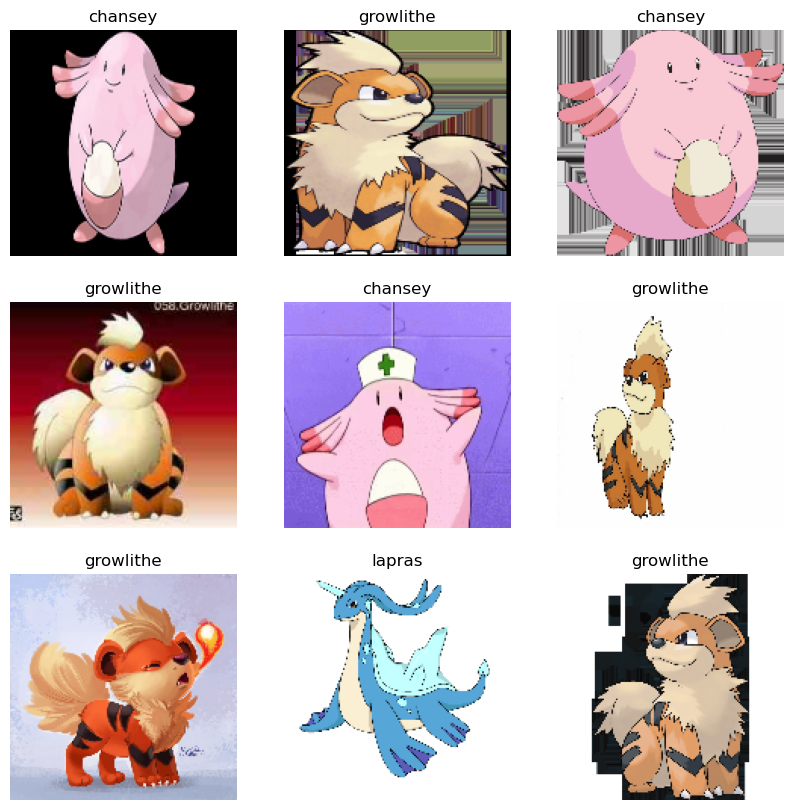

In [7]:
class_names = train_ds.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [9]:
number_of_classes = len(train_ds.class_names)
print(number_of_classes)
print(class_names)

3
['chansey', 'growlithe', 'lapras']


In [12]:
#resize 150x150?
resize_fn = tf.keras.layers.Resizing(150, 150)

train_ds = train_ds.map(lambda x, y: (resize_fn(x), y))
validation_ds = validation_ds.map(lambda x, y: (resize_fn(x), y))
test_ds = test_ds.map(lambda x, y: (resize_fn(x), y))

In [13]:

# Build the model
base_model = tf.keras.applications.Xception(
    weights="imagenet",  # Load weights pre-trained on ImageNet.
    input_shape=(150, 150, 3),
    include_top=False,
)  # Do not include the ImageNet classifier at the top.

# Freeze the base_model
base_model.trainable = False

# Create new model on top
inputs = tf.keras.Input(shape=(150, 150, 3))

# Pre-trained Xception weights require that input be scaled
# from (0, 255) to a range of (-1., +1.), the rescaling layer
# outputs: `(inputs * scale) + offset`
scale_layer = tf.keras.layers.Rescaling(scale=1 / 127.5, offset=-1)
x = scale_layer(inputs)

# The base model contains batchnorm layers. We want to keep them in inference mode
# when we unfreeze the base model for fine-tuning, so we make sure that the
# base_model is running in inference mode here.
x = base_model(x, training=False)
x = tf.keras.layers.GlobalAveragePooling2D()(x)
x = tf.keras.layers.Dropout(0.2)(x)  # Regularize with dropout
outputs = tf.keras.layers.Dense(number_of_classes, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

model.summary(show_trainable=True)


Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 150, 150, 3)       0         Y          
                                                                            
 xception (Functional)       (None, 5, 5, 2048)        20861480  N          
                                                                            
 global_average_pooling2d (G  (None, 2048)             0         Y          
 lobalAveragePooling2D)                                                     
                                                                            
 dropout (Dropout)           (None, 2048)              0         Y          
                                                             

In [14]:
model.compile(optimizer=tf.keras.optimizers.Adam(),
loss="sparse_categorical_crossentropy",
metrics=['accuracy'])

initial_epochs = 4
print("Fitting the top layer of the model")
history = model.fit(train_ds, epochs=initial_epochs, validation_data=validation_ds)


Fitting the top layer of the model
Epoch 1/4
30/30 [==============================] - 34s 860ms/step - loss: 0.7758 - accuracy: 0.6685 - val_loss: 0.3693 - val_accuracy: 0.9522
Epoch 2/4
30/30 [==============================] - 32s 1s/step - loss: 0.2953 - accuracy: 0.9331 - val_loss: 0.2096 - val_accuracy: 0.9713
Epoch 3/4
30/30 [==============================] - 33s 1s/step - loss: 0.2014 - accuracy: 0.9610 - val_loss: 0.1351 - val_accuracy: 0.9856
Epoch 4/4
30/30 [==============================] - 26s 865ms/step - loss: 0.1456 - accuracy: 0.9861 - val_loss: 0.1058 - val_accuracy: 0.9856


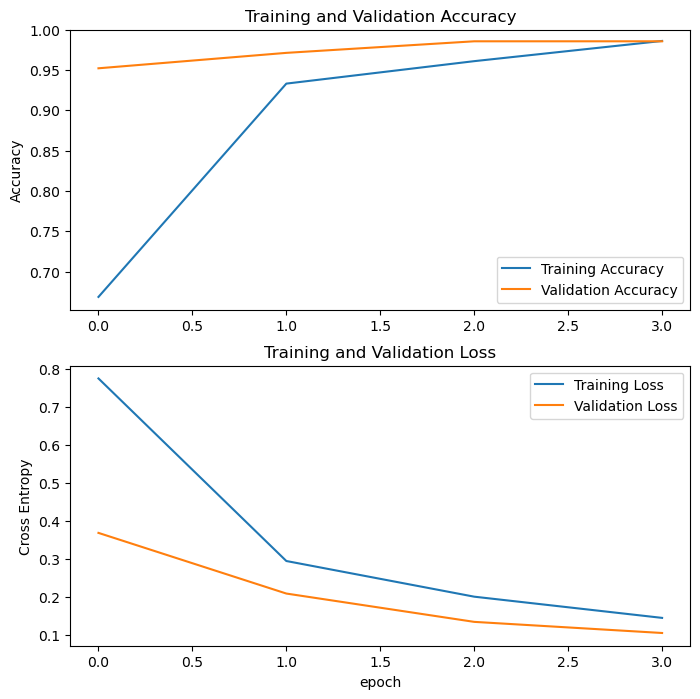

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [17]:
base_model.trainable = True
model.summary(show_trainable=True)

model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-5),  # Low learning rate
    loss="sparse_categorical_crossentropy",
    metrics=['accuracy']
)

epochs = 1
print("Fitting the end-to-end model")
history_fine = model.fit(train_ds, epochs=epochs, validation_data=validation_ds)


Model: "model"
____________________________________________________________________________
 Layer (type)                Output Shape              Param #   Trainable  
 input_3 (InputLayer)        [(None, 150, 150, 3)]     0         Y          
                                                                            
 rescaling (Rescaling)       (None, 150, 150, 3)       0         Y          
                                                                            
 xception (Functional)       (None, 5, 5, 2048)        20861480  Y          
                                                                            


 global_average_pooling2d (G  (None, 2048)             0         Y          
 lobalAveragePooling2D)                                                     
                                                                            
 dropout (Dropout)           (None, 2048)              0         Y          
                                                                            
 dense (Dense)               (None, 3)                 6147      Y          
                                                                            
Total params: 20,867,627
Trainable params: 20,813,099
Non-trainable params: 54,528
____________________________________________________________________________
Fitting the end-to-end model
30/30 [==============================] - 90s 3s/step - loss: 0.0585 - accuracy: 0.9889 - val_loss: 0.0072 - val_accuracy: 1.0000


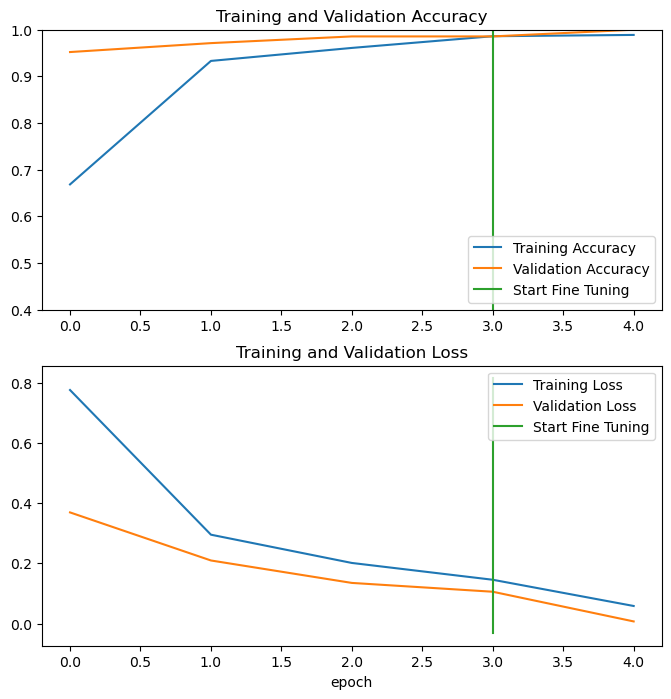

In [18]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.4, 1]) # set the y-axis limits
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.plot([initial_epochs-1,initial_epochs-1],
plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [19]:
print("Test dataset evaluation")
model.evaluate(test_ds)

Test dataset evaluation
4/4 [==============================] - 3s 567ms/step - loss: 0.0047 - accuracy: 1.0000


[0.004702726844698191, 1.0]

Predictions:
 [1 2 1 1 2 1 2 1 2 0 0 1]
Labels:
 [1 2 1 1 2 1 2 1 2 0 0 1]


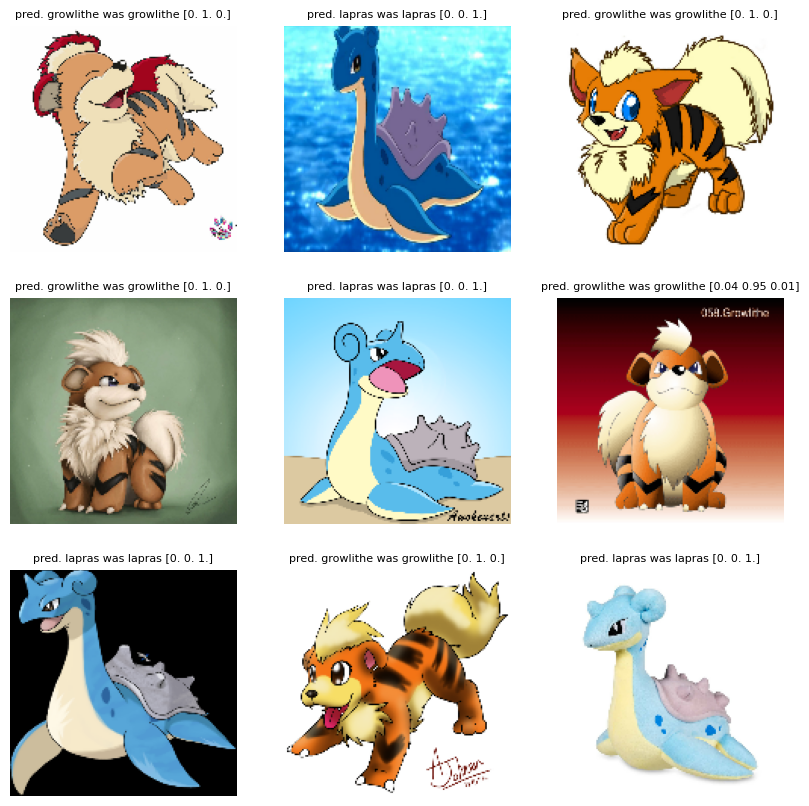

In [22]:
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions_in_percentage = model.predict_on_batch(image_batch)
predictions = np.argmax(predictions_in_percentage, axis=-1)
print('Predictions:\n', predictions)
print('Labels:\n', label_batch)
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title('pred. ' + class_names[predictions[i]] + ' was ' + class_names[label_batch[i]] + ' ' + str(np.round(predictions_in_percentage[i], 2)), fontsize=8)
  plt.axis("off")

In [23]:
model.save('pokemon-model_transferlearning.keras')